Данные - https://www.kaggle.com/usdot/flight-delays
Задачи:
1. Найти аэропорт с минимальной задержкой вылета 
2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
3. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)
4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета  

In [380]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [ ]:
#for j in tqdm(range(len(all_vacancy_ids))):

In [89]:
%%time
df=pd.read_csv('Data/flights.csv', low_memory=False, dtype={'YEAR':str, 'MONTH':str, 'DAY':str, 'DAY_OF_WEEK':str, 'AIRLINE':str})

CPU times: total: 34.5 s
Wall time: 35.8 s


In [90]:
df.shape

(5819079, 31)

In [91]:
df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [385]:
df_aircodes2 = df_aircodes[['IATA_CODE', 'Code_id']].copy()

In [386]:
df_aircodes2.head()

,IATA_CODE,Code_id
0,ABE,10135
1,ABI,10136
2,ABQ,10140
3,ABR,10141
4,ABY,10146


In [387]:
%%time
df_merge1=df.merge(df_aircodes2, how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

CPU times: total: 7.81 s
Wall time: 8 s


In [395]:
df_merge1.head(100)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,Code_id
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
3,2015,1,1,4,AS,122,N413AS,ANC,PDX,50,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
4,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,...,0,1,A,NaN,NaN,NaN,NaN,NaN,ANC,10299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015,1,3,6,DL,1209,N376DA,ANC,SEA,620,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
96,2015,1,3,6,AS,157,N765AS,ANC,OTZ,630,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
97,2015,1,3,6,AS,112,N516AS,ANC,SEA,700,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299
98,2015,1,3,6,AS,55,N762AS,ANC,SCC,710,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,ANC,10299


In [392]:
df_merge1['ORIGIN_AIRPORT'].value_counts().sort_values(ascending=False)

ATL    346836
ORD    285884
DFW    239551
DEN    196055
LAX    194673
        ...  
HYA        83
DLG        77
GST        77
AKN        63
ITH        34
Name: ORIGIN_AIRPORT, Length: 322, dtype: int64

In [393]:
df['ORIGIN_AIRPORT'].value_counts().sort_values(ascending=False)

ATL      346836
ORD      285884
DFW      239551
DEN      196055
LAX      194673
          ...  
13541        11
10165         9
14222         9
13502         6
11503         4
Name: ORIGIN_AIRPORT, Length: 628, dtype: int64

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 object 
 1   MONTH                object 
 2   DAY                  object 
 3   DAY_OF_WEEK          object 
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [97]:
df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [378]:
df.loc[df['ORIGIN_AIRPORT'].str.len () != 3 ].shape

(486165, 31)

In [460]:
n_fl = len(df)
n_fl

5819079

In [381]:
%%time
for i in tqdm(range(n_fl)):    
    if len(df['ORIGIN_AIRPORT'].values[i]) !=3:
        to_replace = df['ORIGIN_AIRPORT'].values[i]
        value = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == to_replace].values[0]
        data2 = df.replace(to_replace, value)
    elif len(df['DESTINATION_AIRPORT'].values[i]) !=3:
        to_replace = df['DESTINATION_AIRPORT'].values[i]
        value = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == to_replace].values[0]
        df = df.replace(to_replace, value)

  0%|          | 0/5819079 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [462]:
%%time
for i in tqdm(range(n_fl)):
    if len(df['ORIGIN_AIRPORT'].values[i]) !=3:
        df.loc[df['ORIGIN_AIRPORT'] == df['ORIGIN_AIRPORT'].values[i], 'ORIGIN_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == df['ORIGIN_AIRPORT'].values[i]].values[0]
    elif len(df['DESTINATION_AIRPORT'].values[i]) !=3:
        df.loc[df['DESTINATION_AIRPORT'] == df['DESTINATION_AIRPORT'].values[i], 'DESTINATION_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == df['DESTINATION_AIRPORT'].values[i]].values[0]

  0%|          | 0/5819079 [00:00<?, ?it/s]

CPU times: total: 4min 54s
Wall time: 4min 56s


In [463]:
df1 = df.copy()

In [ ]:
#print(data2['ORIGIN_AIRPORT'].values[486165])

In [456]:
%%time
data2 = df.loc[df['ORIGIN_AIRPORT'].str.len () != 3 ]

CPU times: total: 1.94 s
Wall time: 1.83 s


In [457]:
data2.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
4385712,2015,10,1,4,AA,1230,N3DBAA,14747,11298,5,...,543.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385713,2015,10,1,4,DL,1805,N696DL,14771,13487,5,...,528.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385714,2015,10,1,4,NK,612,N602NK,12889,13487,5,...,448.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385715,2015,10,1,4,AA,260,N3GNAA,12892,13303,10,...,813.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385716,2015,10,1,4,AA,1982,N914UY,14771,11057,10,...,750.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [447]:
data2 = data1[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]

In [453]:
data2.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
4385712,2015,10,1,4,AA,1230,N3DBAA,14747,11298,5,...,543.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385713,2015,10,1,4,DL,1805,N696DL,14771,13487,5,...,528.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385714,2015,10,1,4,NK,612,N602NK,12889,13487,5,...,448.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385715,2015,10,1,4,AA,260,N3GNAA,12892,13303,10,...,813.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385716,2015,10,1,4,AA,1982,N914UY,14771,11057,10,...,750.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385717,2015,10,1,4,UA,684,N495UA,14771,13930,14,...,602.0,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385718,2015,10,1,4,UA,1171,N68452,12892,13930,14,...,614.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385719,2015,10,1,4,AA,448,N179UW,14869,11057,15,...,602.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385720,2015,10,1,4,AA,2406,N859AA,12892,11298,15,...,510.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385721,2015,10,1,4,DL,1617,N809DN,12892,13487,20,...,543.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [459]:
data2.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
4385712,2015,10,1,4,AA,1230,N3DBAA,SEA,DFW,5,...,543.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385713,2015,10,1,4,DL,1805,N696DL,SFO,MSP,5,...,528.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385714,2015,10,1,4,NK,612,N602NK,LAS,MSP,5,...,448.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385715,2015,10,1,4,AA,260,N3GNAA,LAX,MIA,10,...,813.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385716,2015,10,1,4,AA,1982,N914UY,SFO,CLT,10,...,750.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385717,2015,10,1,4,UA,684,N495UA,SFO,ORD,14,...,602.0,-33.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385718,2015,10,1,4,UA,1171,N68452,LAX,ORD,14,...,614.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385719,2015,10,1,4,AA,448,N179UW,SLC,CLT,15,...,602.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385720,2015,10,1,4,AA,2406,N859AA,LAX,DFW,15,...,510.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385721,2015,10,1,4,DL,1617,N809DN,LAX,MSP,20,...,543.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [401]:
data2.shape

(486165, 2)

In [420]:
to_replace = data2['ORIGIN_AIRPORT'].values[1]
value = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == to_replace].values[0]
data2 = data2.replace(to_replace, value)

Синтаксис: df.loc[ df[“column_name”] == “some_value”, “column_name”] = “значение”

some_value = значение, которое необходимо заменить

значение = значение, которое следует поместить вместо него.

In [425]:
data2.loc[data2['ORIGIN_AIRPORT'] == data2['ORIGIN_AIRPORT'].values[1], 'ORIGIN_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == data2['ORIGIN_AIRPORT'].values[1]].values[0]

C:\Users\pc\AppData\Local\Temp\ipykernel_4520\2292749269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[data2['ORIGIN_AIRPORT'] == data2['ORIGIN_AIRPORT'].values[1], 'ORIGIN_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == data2['ORIGIN_AIRPORT'].values[1]].values[0]


In [414]:
data2['ORIGIN_AIRPORT'].index[0]

4385712

In [404]:
print(data2['ORIGIN_AIRPORT'].values[1])

14771


In [405]:
print(df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == data2['ORIGIN_AIRPORT'].values[1]].values[0])

SFO


In [427]:
N_fl = len(data2)
N_fl

486165

In [455]:
%%time
for i in tqdm(range(N_fl)):
    if len(data2['ORIGIN_AIRPORT'].values[i]) !=3:
        to_replace = data2['ORIGIN_AIRPORT'].values[i]
        value = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == to_replace].values[0]
        data2 = data2.replace(to_replace, value)
    elif len(data2['DESTINATION_AIRPORT'].values[i]) !=3:
        to_replace = data2['DESTINATION_AIRPORT'].values[i]
        value = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == to_replace].values[0]
        data2 = data2.replace(to_replace, value)
    

  0%|          | 0/486165 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [458]:
%%time
for i in tqdm(range(N_fl)):
    if len(data2['ORIGIN_AIRPORT'].values[i]) !=3:
        data2.loc[data2['ORIGIN_AIRPORT'] == data2['ORIGIN_AIRPORT'].values[i], 'ORIGIN_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == data2['ORIGIN_AIRPORT'].values[i]].values[0]
    elif len(data2['DESTINATION_AIRPORT'].values[i]) !=3:
        data2.loc[data2['DESTINATION_AIRPORT'] == data2['DESTINATION_AIRPORT'].values[i], 'DESTINATION_AIRPORT'] = df_aircodes['IATA_CODE'].loc[df_aircodes['Code_id'] == data2['DESTINATION_AIRPORT'].values[i]].values[0]
    

  0%|          | 0/486165 [00:00<?, ?it/s]

CPU times: total: 26.1 s
Wall time: 26.4 s


In [367]:
data3 = data2.loc[data2['DESTINATION_AIRPORT'].str.len() != 3]

In [366]:
data3.head()

,ORIGIN_AIRPORT,DESTINATION_AIRPORT


In [355]:
data3.shape

(0, 2)

In [285]:
#for i in range(N_flights):
    #if len(data1['ORIGIN_AIRPORT'][i]) != 3:
       # to_replace = data1['ORIGIN_AIRPORT'][i]
        
       # value = df_aircodes[['IATA_CODE']].loc[df_aircodes['Code_id'] == data1['ORIGIN_AIRPORT'][i]].values[0][0]
        #data1 = data1.replace(to_replace, value)
        
       # print('replaced',to_replace,'with',value)
    #elif len(data1['DESTINATION_AIRPORT'][i]) != 3:
        #to_replace = data1['DESTINATION_AIRPORT'][i]
        
       # value = aircode_dict[df_fl['DESTINATION_AIRPORT'][i]]
        
        #data1 = data1.replace(to_replace, value)
        #print('replaced',to_replace,'with',value)***

In [ ]:
df_aircodes.iloc

In [187]:
df_digit_aircodes=pd.read_csv('Data/L_AIRPORT_ID.csv', low_memory=False)

In [188]:
# df_digit_aircodes.rename(columns = {'Code':'Code_digit'}, inplace = True )

In [189]:
df_digit_aircodes.head()

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


In [190]:
df_digit_aircodes.shape

(6414, 2)

In [191]:
df_digit_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6414 entries, 0 to 6413
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         6414 non-null   int64 
 1   Description  6414 non-null   object
dtypes: int64(1), object(1)
memory usage: 100.3+ KB


In [192]:
df_digit_aircodes['Code'] = df_digit_aircodes['Code'].astype(str)

In [193]:
df_digit_aircodes.head(10)

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"
5,10007,"Klawock, AK: Klawock Seaplane Base"
6,10008,"Elizabeth Island, AK: Elizabeth Island Airport"
7,10009,"Homer, AK: Augustin Island"
8,10010,"Hudson, NY: Columbia County"
9,10011,"Peach Springs, AZ: Grand Canyon West"


In [194]:
df_digit_aircodes.shape

(6414, 2)

In [195]:
df_other_aircodes=pd.read_csv('Data/airports.csv', low_memory=False)

In [196]:
df_other_aircodes.head(10)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
5,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
6,ACT,Waco Regional Airport,Waco,TX,USA,31.61129,-97.23052
7,ACV,Arcata Airport,Arcata/Eureka,CA,USA,40.97812,-124.10862
8,ACY,Atlantic City International Airport,Atlantic City,NJ,USA,39.45758,-74.57717
9,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603


In [197]:
df_other_aircodes.shape

(322, 7)

In [198]:
df_other_aircodes.tail()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023
321,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597


In [199]:
#df_aircodes=df_other_aircodes.merge(df_digit_aircodes, how='inner', on='Description')

In [200]:
# print(df_other_aircodes.to_string())

In [201]:
df_norm_aircodes=pd.read_csv('Data/L_AIRPORT.csv', low_memory=False)

In [202]:
df_norm_aircodes.head()

,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [203]:
df_norm_aircodes.shape

(6429, 2)

In [204]:
df_merge_aircodes=df_digit_aircodes.merge(df_norm_aircodes, how='inner', on='Description')

In [205]:
df_merge_aircodes.shape

(6443, 3)

In [206]:
df_merge_aircodes.isna().sum()

Code_x         0
Description    0
Code_y         0
dtype: int64

In [207]:
df_merge_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6443 entries, 0 to 6442
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code_x       6443 non-null   object
 1   Description  6443 non-null   object
 2   Code_y       6443 non-null   object
dtypes: object(3)
memory usage: 201.3+ KB


In [208]:
df_merge_aircodes.rename(columns = {'Code_x':'Code_id', 'Code_y':'Code'}, inplace = True )

In [209]:
df_merge_aircodes.shape

(6443, 3)

In [210]:
df_aircodes=df_other_aircodes.merge(df_merge_aircodes, how='inner', left_on='IATA_CODE', right_on='Code')

In [211]:
df_aircodes.shape

(323, 10)

In [212]:
df_aircodes.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Code_id,Description,Code
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,10135,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",ABE
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,10136,"Abilene, TX: Abilene Regional",ABI
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,10140,"Albuquerque, NM: Albuquerque International Sun...",ABQ
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,10141,"Aberdeen, SD: Aberdeen Regional",ABR
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,10146,"Albany, GA: Southwest Georgia Regional",ABY


In [13]:
# df_aircodes['Code_y'].to_string
# df_aircodes['Code_y'] = df_aircodes['Code_y'].astype(str)

In [14]:
# df_aircodes['Code_x'] = df_aircodes['Code_x'].astype(str)

In [57]:
# df[df.text.isna()].values
# df_aircodes[df_aircodes.Code_y.isna()].values

In [58]:
# df_aircodes[df_aircodes.Code_x.isna()].values

In [213]:
df_aircodes.tail(6)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Code_id,Description,Code
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982,15841,"Wrangell, AK: Wrangell Airport",WRG
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764,15897,"West Yellowstone, MT: Yellowstone",WYS
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681,15919,"Fayetteville, AR: Northwest Arkansas Regional",XNA
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023,15991,"Yakutat, AK: Yakutat Airport",YAK
321,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597,13785,"Yuma, AZ: Yuma MCAS/Yuma International",YUM
322,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597,16218,"Yuma, AZ: Yuma MCAS/Yuma International",YUM


In [276]:
print(df_aircodes[['IATA_CODE']].loc[df_aircodes['Code_id'] == '15897'].values[0][0])

WYS


In [284]:
print(df_aircodes[['IATA_CODE']].loc[df_aircodes['Code_id'] == '15897'].values[0][0])

WYS


In [268]:
one.values[0][0]

'WRG'

In [219]:
df_aircodes['Code_id'].value_counts().sort_values(ascending=False)

10135    1
11259    1
10140    1
10141    1
10146    1
        ..
15919    1
15991    1
13785    1
15582    1
16218    1
Name: Code_id, Length: 323, dtype: int64

In [224]:
df_aircodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 322
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IATA_CODE    323 non-null    object 
 1   AIRPORT      323 non-null    object 
 2   CITY         323 non-null    object 
 3   STATE        323 non-null    object 
 4   COUNTRY      323 non-null    object 
 5   LATITUDE     320 non-null    float64
 6   LONGITUDE    320 non-null    float64
 7   Code_id      323 non-null    object 
 8   Description  323 non-null    object 
 9   Code         323 non-null    object 
dtypes: float64(2), object(8)
memory usage: 27.8+ KB


In [5]:
# print(df_aircodes.to_string())

In [46]:
# print(df_aircodes1.to_string())

In [55]:
# df_aircodes1=df_digit_aircodes.merge(df_norm_aircodes, how='inner', on='Description')

In [54]:
# df_aircodes1.shape

In [53]:
# df_aircodes1.info()

In [52]:
# df_aircodes1.isna().sum()

In [51]:
# df_aircodes1.tail()

In [50]:
# df_aircodes2=df_digit_aircodes.merge(df_norm_aircodes, how='right', on='Description')

In [49]:
# df_aircodes2.shape

In [48]:
# df_aircodes2.isna().sum()

In [47]:
# df_aircodes2[df_aircodes2.Code_x.isna()].values

In [ ]:
lst = ['10006', '1G4', '10012', '10023', 
         'KTH', 'Swift', 'Go'] 
 
# Calling DataFrame constructor on list 
dframe = pd.DataFrame(lst) 
print(dframe)
Источник: https://pythonpip.ru/examples/kak-sozdat-dataframes-pandas-v-python-7-metodov

In [5]:
df.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [5]:
# df.loc[len(df['ORIGIN_AIRPORT']) != 3].sum()
one = df.loc[df['ORIGIN_AIRPORT'].str.len () != 3 ]

In [8]:
one.shape[0]

486165

In [7]:
one

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
4385712,2015,10,1,4,AA,1230,N3DBAA,14747,11298,5,...,543.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385713,2015,10,1,4,DL,1805,N696DL,14771,13487,5,...,528.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385714,2015,10,1,4,NK,612,N602NK,12889,13487,5,...,448.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385715,2015,10,1,4,AA,260,N3GNAA,12892,13303,10,...,813.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4385716,2015,10,1,4,AA,1982,N914UY,14771,11057,10,...,750.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871872,2015,10,31,6,B6,98,N715JB,11292,12478,2359,...,427.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4871873,2015,10,31,6,B6,839,N834JB,12478,10732,2359,...,322.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4871874,2015,10,31,6,B6,1503,N907JB,12478,14843,2359,...,502.0,80.0,0,0,NaN,0.0,0.0,80.0,0.0,0.0
4871875,2015,10,31,6,UA,1696,N68836,14747,12266,2359,...,442.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
one.to_string()

NameError: name 'one' is not defined

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [7]:
v = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].median().sort_values(ascending=True)

In [8]:
v

ORIGIN_AIRPORT
15991   -14.5
10926   -13.0
YAK     -11.0
14254    -9.5
10333    -9.5
         ... 
GUM       6.0
GST       7.5
14025     8.0
ADK      11.0
10165    12.0
Name: DEPARTURE_DELAY, Length: 628, dtype: float64

<Axes: ylabel='ORIGIN_AIRPORT'>

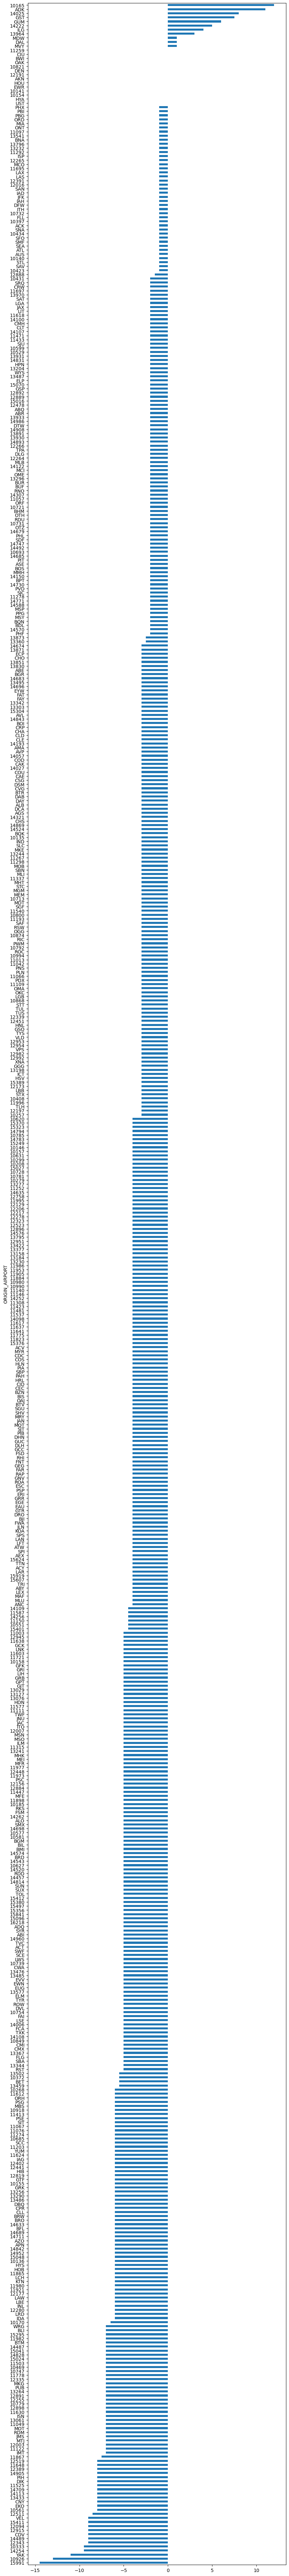

In [10]:
v.plot(kind = 'barh', figsize=(10, 100))

In [11]:
v.shape

(628,)

In [13]:
# df[df.DEPARTURE_DELAY.isna()].DEPARTURE_DELAY.values

array([nan, nan, nan, ..., nan, nan, nan])

In [42]:
# df1 = df.replace({np.nan:None})

In [45]:
# print(df1['DEPARTURE_DELAY'].dtype) 

object


In [54]:
# df1['DEPARTURE_DELAY'] = df1['DEPARTURE_DELAY'].astype (float)

## убираю данные за октябрь, где только цифры

In [93]:
%%time
df1 = df.loc[df['ORIGIN_AIRPORT'].str.len () == 3 ]

CPU times: total: 6.47 s
Wall time: 7.45 s


In [98]:
df1.shape

(5332914, 31)

In [99]:
df1.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332914 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 object 
 1   MONTH                object 
 2   DAY                  object 
 3   DAY_OF_WEEK          object 
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

##### 1. Найти аэропорт с минимальной задержкой вылета

In [12]:
df2 = df1.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].median().sort_values(ascending=True)

<Axes: ylabel='ORIGIN_AIRPORT'>

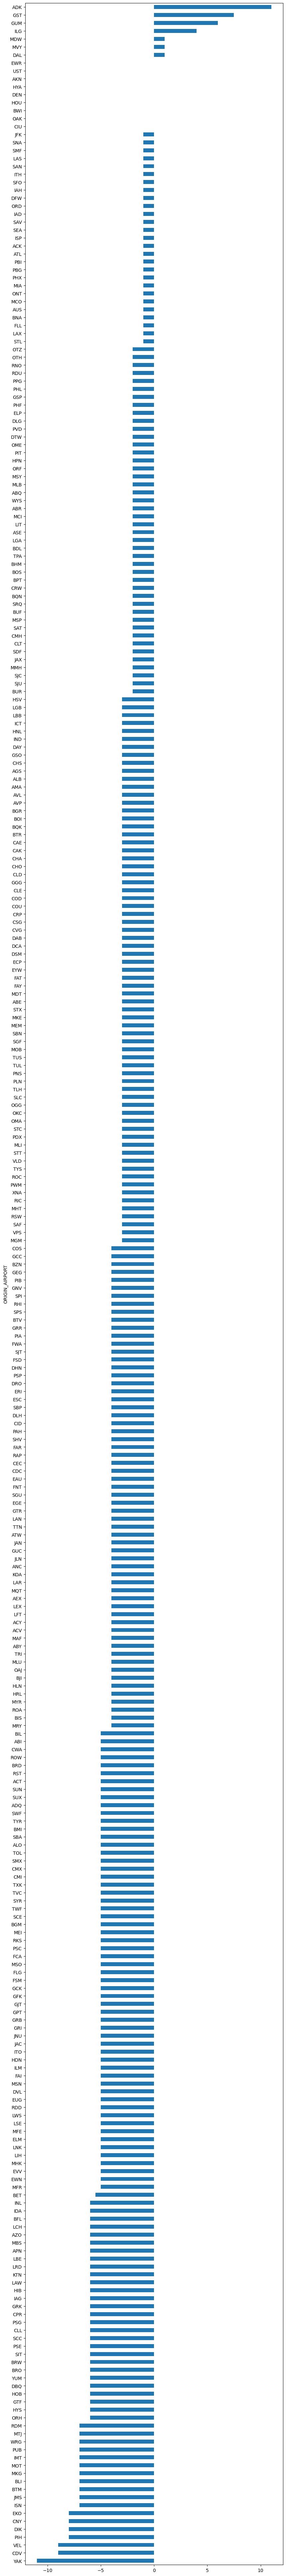

In [13]:
df2.plot(kind='barh', figsize=(10, 100))

In [14]:
df2.index[0]

'YAK'

YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023

#### 2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport

LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807

In [77]:
df3 = df.loc[df['DESTINATION_AIRPORT'] == 'LAX' ]

In [78]:
df3.shape

(194696, 31)

In [79]:
df3.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
101,2015,1,1,4,OO,6512,N925SW,FAT,LAX,535,...,650.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
103,2015,1,1,4,OO,4986,N719SK,AUS,LAX,538,...,654.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
129,2015,1,1,4,OO,2599,N435SW,DEN,LAX,545,...,811.0,56.0,0,0,NaN,0.0,0.0,56.0,0.0,0.0
131,2015,1,1,4,OO,6457,N560SW,SMX,LAX,545,...,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN
156,2015,1,1,4,UA,1222,N68452,MCO,LAX,555,...,840.0,4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
df4 = df3.groupby('AIRLINE')['ARRIVAL_DELAY'].median().sort_values(ascending=True)

<Axes: ylabel='AIRLINE'>

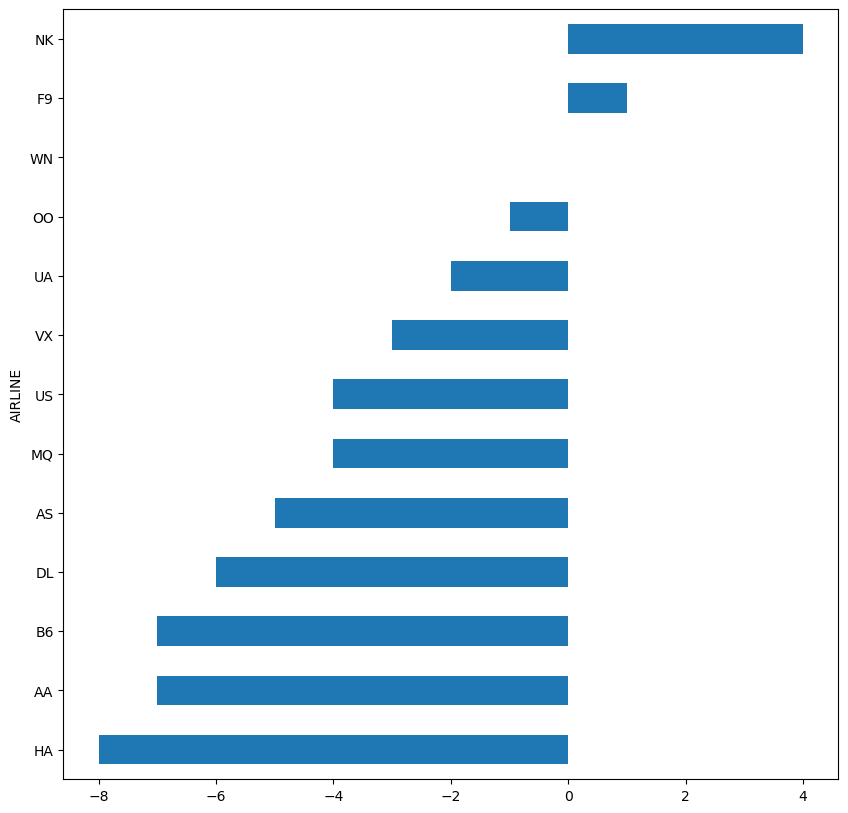

In [82]:
df4.plot(kind='barh', figsize=(10, 10))

In [83]:
df4.index[0]

'HA'

HA,Hawaiian Airlines Inc.

#### 3. Найти аэропорт, где самолёты проводят больше всего времени на рулении (среднее значение)

In [84]:
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
df5 = df1.groupby('ORIGIN_AIRPORT')['TAXI_OUT'].mean().sort_values(ascending=True)

In [89]:
df5.shape

(322,)

<Axes: ylabel='ORIGIN_AIRPORT'>

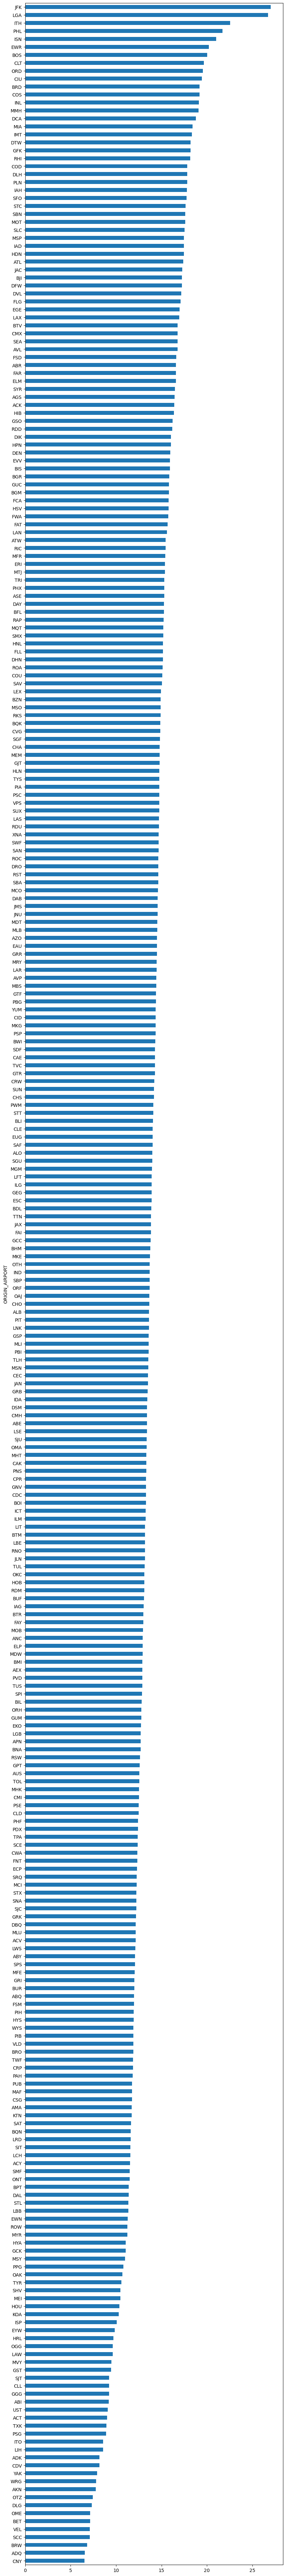

In [90]:
df5.plot(kind='barh', figsize=(10, 100))

In [91]:
df5.index[0]

'CNY'

CNY,Canyonlands Field,Moab,UT,USA,38.75496,-109.75484

In [92]:
df6 = df1.groupby('DESTINATION_AIRPORT')['TAXI_IN'].mean().sort_values(ascending=True)

In [93]:
df6.shape

(322,)

<Axes: ylabel='DESTINATION_AIRPORT'>

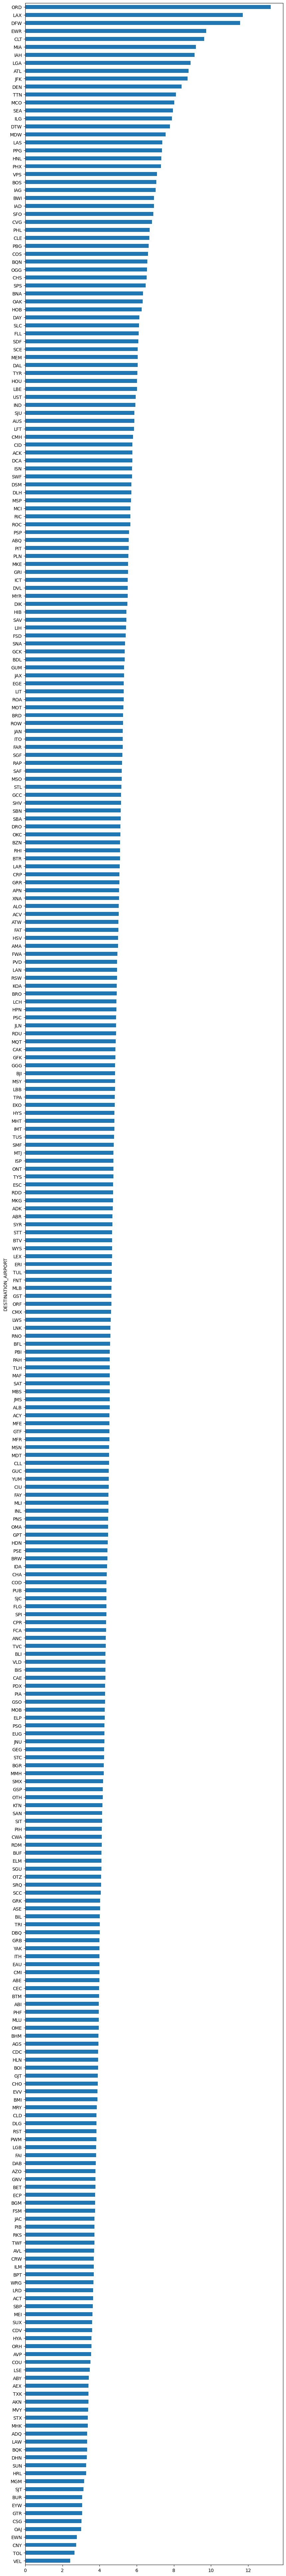

In [94]:
df6.plot(kind='barh', figsize=(10, 100))

In [95]:
df6.index[0]

'VEL'

VEL,Valdez Airport,Vernal,UT,USA,40.44090,-109.50992

##### 4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

In [464]:
df1['ORIGIN_AIRPORT'].value_counts()

ATL    379424
ORD    313536
DFW    260595
DEN    214191
LAX    212401
        ...  
HYA        83
DLG        77
GST        77
AKN        63
ITH        34
Name: ORIGIN_AIRPORT, Length: 322, dtype: int64

In [465]:
%%time
df7 = df1.loc[df1['ORIGIN_AIRPORT'] == 'ATL' ]

CPU times: total: 656 ms
Wall time: 710 ms


In [466]:
df7.shape

(379424, 31)

In [467]:
df7.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
109,2015,1,1,4,EV,3268,N14998,ATL,IAD,540,...,739.0,14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
304,2015,1,1,4,F9,902,N949FR,ATL,TTN,600,...,814.0,24.0,0,0,NaN,5.0,0.0,19.0,0.0,0.0
560,2015,1,1,4,AA,1635,N025AA,ATL,DFW,625,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
729,2015,1,1,4,DL,886,N918DL,ATL,LGA,645,...,901.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
749,2015,1,1,4,OO,4974,N792SK,ATL,IAH,646,...,809.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


###### Решение посредством группировки аэропортов прибытия и вычисления по каждому медианного значения задержки

In [468]:
df8 = df7.groupby('DESTINATION_AIRPORT')['ARRIVAL_DELAY'].median().sort_values(ascending=True)

<Axes: ylabel='DESTINATION_AIRPORT'>

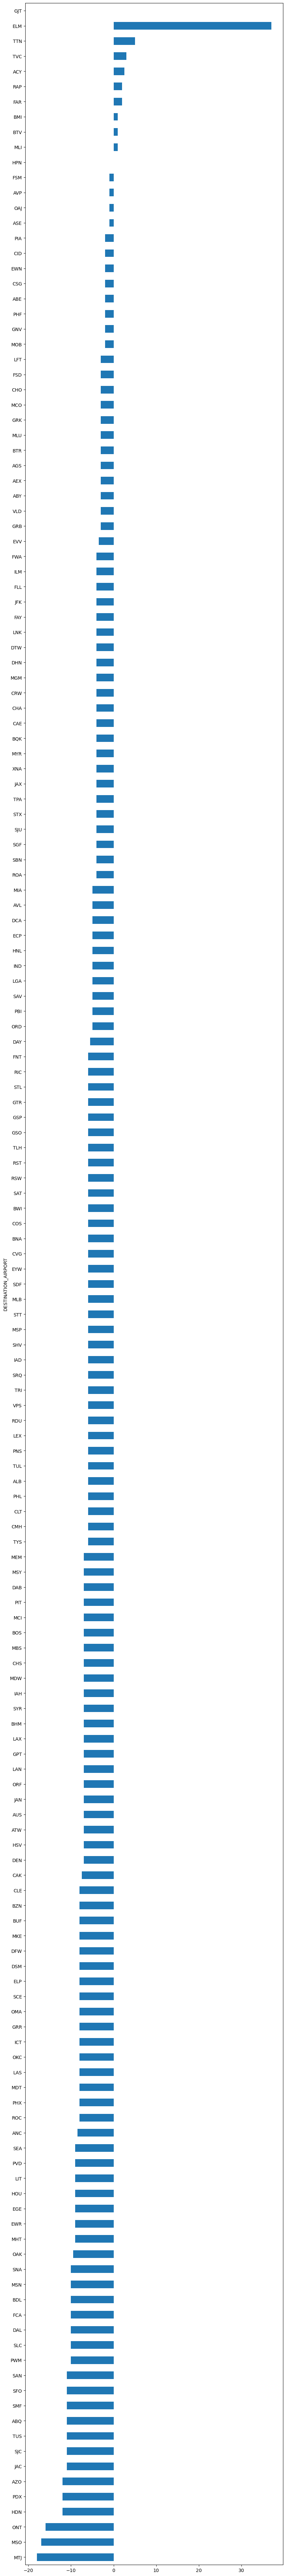

In [469]:
df8.plot(kind='barh', figsize=(10, 100))

In [470]:
df8.index[0], df8.index[1], df8.index[2]

('MTJ', 'MSO', 'ONT')

###### Решение через построение модели

In [471]:
df7.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
109,2015,1,1,4,EV,3268,N14998,ATL,IAD,540,...,739.0,14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
304,2015,1,1,4,F9,902,N949FR,ATL,TTN,600,...,814.0,24.0,0,0,NaN,5.0,0.0,19.0,0.0,0.0
560,2015,1,1,4,AA,1635,N025AA,ATL,DFW,625,...,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN
729,2015,1,1,4,DL,886,N918DL,ATL,LGA,645,...,901.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
749,2015,1,1,4,OO,4974,N792SK,ATL,IAH,646,...,809.0,7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [472]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379424 entries, 109 to 5818950
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 379424 non-null  object 
 1   MONTH                379424 non-null  object 
 2   DAY                  379424 non-null  object 
 3   DAY_OF_WEEK          379424 non-null  object 
 4   AIRLINE              379424 non-null  object 
 5   FLIGHT_NUMBER        379424 non-null  int64  
 6   TAIL_NUMBER          379220 non-null  object 
 7   ORIGIN_AIRPORT       379424 non-null  object 
 8   DESTINATION_AIRPORT  379424 non-null  object 
 9   SCHEDULED_DEPARTURE  379424 non-null  int64  
 10  DEPARTURE_TIME       376945 non-null  float64
 11  DEPARTURE_DELAY      376945 non-null  float64
 12  TAXI_OUT             376878 non-null  float64
 13  WHEELS_OFF           376878 non-null  float64
 14  SCHEDULED_TIME       379424 non-null  float64
 15  ELAPSED_TIME  

In [473]:
df7['DESTINATION_AIRPORT'].value_counts()

MCO    8964
LGA    8909
FLL    8092
TPA    7727
DFW    7691
       ... 
RAP      15
MBS      15
LAN      13
ONT       3
GJT       1
Name: DESTINATION_AIRPORT, Length: 169, dtype: int64

In [474]:
df9=df7[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY']].copy()

In [475]:
df9.shape

(379424, 7)

In [476]:
df9.isna().sum()

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
ARRIVAL_DELAY          3409
dtype: int64

In [477]:
df9.dropna(inplace=True)

In [478]:
df9['DESTINATION_AIRPORT'].value_counts()

MCO    8908
LGA    8627
FLL    8059
TPA    7684
DFW    7569
       ... 
RAP      15
MBS      15
ELM      13
LAN      13
ONT       3
Name: DESTINATION_AIRPORT, Length: 168, dtype: int64

In [479]:
%%time
df10 = df9.loc[df9['DESTINATION_AIRPORT'] == 'MCO']

CPU times: total: 31.2 ms
Wall time: 33.1 ms


In [480]:
df10.shape

(8908, 7)

In [481]:
df10.isna().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
ARRIVAL_DELAY          0
dtype: int64

In [482]:
df10['DATE'] = df10['DAY'] + '.' + df10['MONTH'] + '.' + df10['YEAR']

C:\Users\pc\AppData\Local\Temp\ipykernel_4520\348288625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['DATE'] = df10['DAY'] + '.' + df10['MONTH'] + '.' + df10['YEAR']


In [483]:
df10.head(100)

,YEAR,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,DATE
815,2015,1,1,4,ATL,MCO,-7.0,1.1.2015
2384,2015,1,1,4,ATL,MCO,5.0,1.1.2015
5124,2015,1,1,4,ATL,MCO,-2.0,1.1.2015
5576,2015,1,1,4,ATL,MCO,-7.0,1.1.2015
6910,2015,1,1,4,ATL,MCO,34.0,1.1.2015
...,...,...,...,...,...,...,...,...
69295,2015,1,5,1,ATL,MCO,-3.0,5.1.2015
69746,2015,1,5,1,ATL,MCO,-11.0,5.1.2015
70445,2015,1,5,1,ATL,MCO,-9.0,5.1.2015
71179,2015,1,5,1,ATL,MCO,10.0,5.1.2015


In [484]:
df10['DATE'].value_counts()

27.12.2015    28
20.12.2015    28
23.12.2015    27
22.12.2015    27
29.12.2015    27
              ..
24.12.2015    18
24.1.2015     18
24.2.2015     18
1.1.2015      18
25.2.2015     17
Name: DATE, Length: 365, dtype: int64

In [485]:
df10['DATE'] = pd.to_datetime(df10['DATE'], format = "%d.%m.%Y")

C:\Users\pc\AppData\Local\Temp\ipykernel_4520\2934431896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['DATE'] = pd.to_datetime(df10['DATE'], format = "%d.%m.%Y")


In [486]:
df10['DATE'].value_counts()

2015-12-27    28
2015-12-20    28
2015-12-23    27
2015-12-22    27
2015-12-29    27
              ..
2015-12-24    18
2015-01-24    18
2015-02-24    18
2015-01-01    18
2015-02-25    17
Name: DATE, Length: 365, dtype: int64

In [487]:
# df10['ONE'] = df10.groupby('DATE')['ARRIVAL_DELAY'].median()

In [488]:
df10.tail(15)

,YEAR,MONTH,DAY,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ARRIVAL_DELAY,DATE
5810051,2015,12,31,4,ATL,MCO,-10.0,2015-12-31
5810965,2015,12,31,4,ATL,MCO,45.0,2015-12-31
5811880,2015,12,31,4,ATL,MCO,23.0,2015-12-31
5812819,2015,12,31,4,ATL,MCO,-4.0,2015-12-31
5813610,2015,12,31,4,ATL,MCO,-16.0,2015-12-31
5813672,2015,12,31,4,ATL,MCO,7.0,2015-12-31
5814547,2015,12,31,4,ATL,MCO,-7.0,2015-12-31
5815548,2015,12,31,4,ATL,MCO,30.0,2015-12-31
5815829,2015,12,31,4,ATL,MCO,-11.0,2015-12-31
5816929,2015,12,31,4,ATL,MCO,-7.0,2015-12-31


In [489]:
df11 = df10.groupby('DATE')['ARRIVAL_DELAY'].median()

In [490]:
df11.shape

(365,)

In [491]:
df11.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Series name: ARRIVAL_DELAY
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [492]:
df11.head(334)

DATE
2015-01-01    -1.5
2015-01-02     3.0
2015-01-03     3.0
2015-01-04    11.0
2015-01-05    -3.0
              ... 
2015-11-26    -6.5
2015-11-27    -9.0
2015-11-28    -6.5
2015-11-29    -4.0
2015-11-30    -5.0
Name: ARRIVAL_DELAY, Length: 334, dtype: float64

In [493]:
df11 = df11.sort_values(by='data').reset_index(drop=True)

TypeError: Series.sort_values() got an unexpected keyword argument 'by'

In [494]:
df11.tail()

DATE
2015-12-27     7.0
2015-12-28     1.5
2015-12-29    14.0
2015-12-30    48.0
2015-12-31     1.0
Name: ARRIVAL_DELAY, dtype: float64

<Axes: xlabel='DATE'>

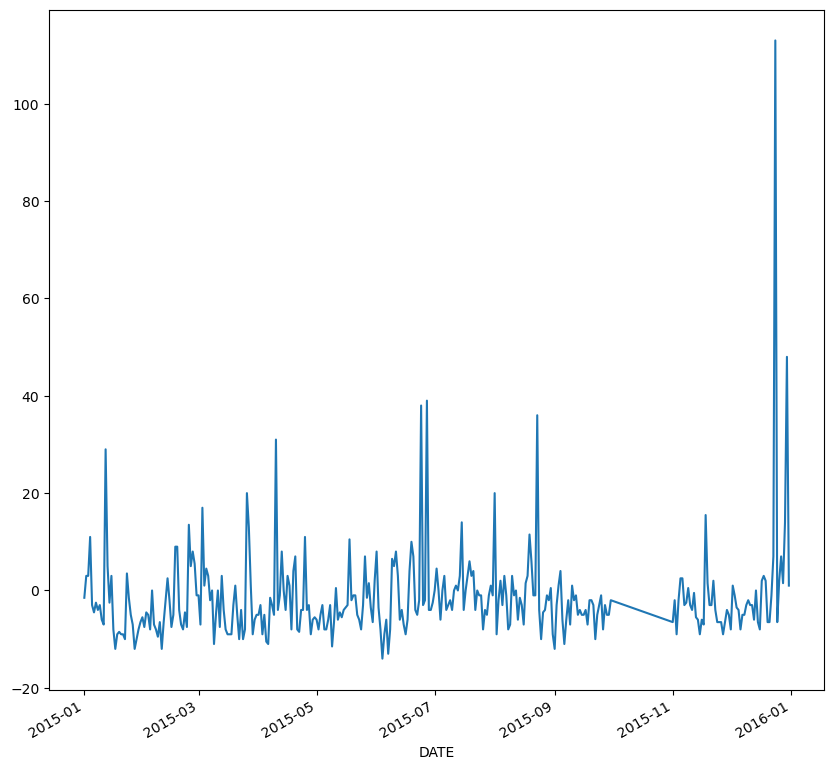

In [178]:
df11.plot(figsize=(10, 10))

<Axes: xlabel='DATE'>

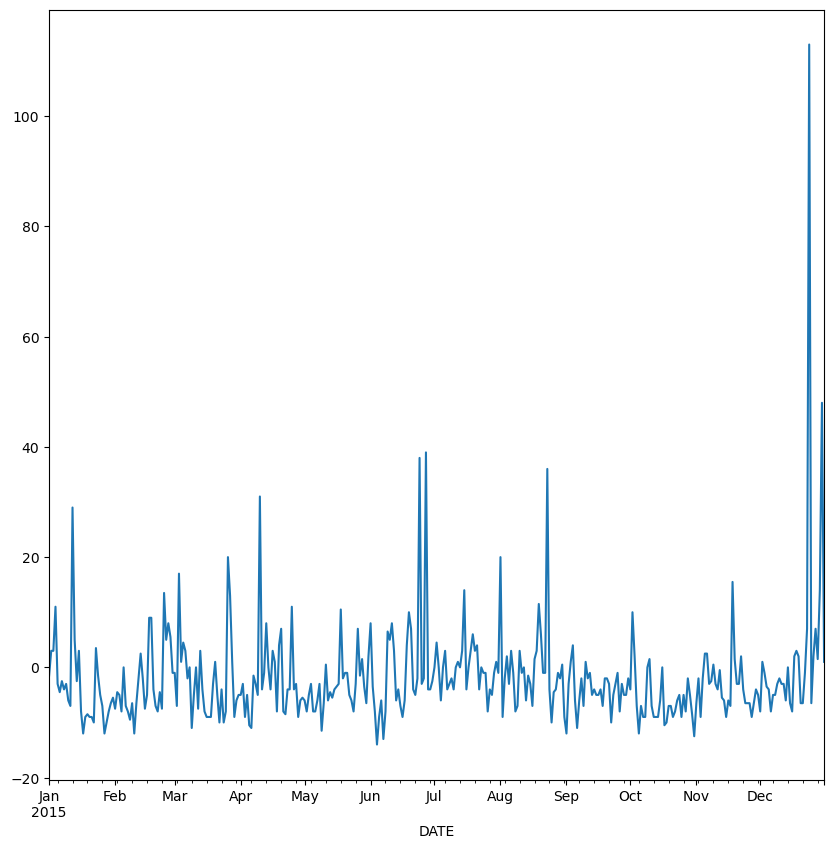

In [495]:
df11.plot(figsize=(10, 10))

In [42]:
# df7['DATE'] = df7['DAY'] + '.' + df7['MONTH'] + '.' + df7['YEAR']

In [43]:
# df7['DATE'] = pd.to_datetime(df7['DATE'], format = "%d.%m.%Y")

In [75]:
def make_new_features(data, max_lag):
    data['MONTH']
    data['DAY']
    data['DAY_OF_WEEK']
    data['DESTINATION_AIRPORT']
    
    for lag in range(1,max_lag+1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)
    
    # data['roll_mean'] = data['ARRIVAL_DELAY'].shift().rolling(roll).mean()

In [76]:
make_new_features(df7,10)

C:\Users\pc\AppData\Local\Temp\ipykernel_4520\2360975583.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)
C:\Users\pc\AppData\Local\Temp\ipykernel_4520\2360975583.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)
C:\Users\pc\AppData\Local\Temp\ipykernel_4520\2360975583.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [79]:
df7.head(20)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
109,2015,1,1,4,EV,3268,N14998,ATL,IAD,540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,2015,1,1,4,F9,902,N949FR,ATL,TTN,600,...,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
560,2015,1,1,4,AA,1635,N025AA,ATL,DFW,625,...,24.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,2015,1,1,4,DL,886,N918DL,ATL,LGA,645,...,NaN,24.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,2015,1,1,4,OO,4974,N792SK,ATL,IAH,646,...,8.0,NaN,24.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
815,2015,1,1,4,DL,1818,N555NW,ATL,MCO,655,...,7.0,8.0,NaN,24.0,14.0,NaN,NaN,NaN,NaN,NaN
863,2015,1,1,4,US,461,N540UW,ATL,CLT,700,...,-7.0,7.0,8.0,NaN,24.0,14.0,NaN,NaN,NaN,NaN
868,2015,1,1,4,AA,17,N019AA,ATL,MIA,700,...,-11.0,-7.0,7.0,8.0,NaN,24.0,14.0,NaN,NaN,NaN
959,2015,1,1,4,NK,231,N620NK,ATL,FLL,700,...,-10.0,-11.0,-7.0,7.0,8.0,NaN,24.0,14.0,NaN,NaN
1167,2015,1,1,4,DL,2499,N696DL,ATL,SLC,720,...,17.0,-10.0,-11.0,-7.0,7.0,8.0,NaN,24.0,14.0,NaN


In [78]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346836 entries, 109 to 5818950
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 346836 non-null  object 
 1   MONTH                346836 non-null  object 
 2   DAY                  346836 non-null  object 
 3   DAY_OF_WEEK          346836 non-null  int64  
 4   AIRLINE              346836 non-null  object 
 5   FLIGHT_NUMBER        346836 non-null  int64  
 6   TAIL_NUMBER          346638 non-null  object 
 7   ORIGIN_AIRPORT       346836 non-null  object 
 8   DESTINATION_AIRPORT  346836 non-null  object 
 9   SCHEDULED_DEPARTURE  346836 non-null  int64  
 10  DEPARTURE_TIME       344384 non-null  float64
 11  DEPARTURE_DELAY      344384 non-null  float64
 12  TAXI_OUT             344319 non-null  float64
 13  WHEELS_OFF           344319 non-null  float64
 14  SCHEDULED_TIME       346836 non-null  float64
 15  ELAPSED_TIME  